---
title: "Image Recognition with a Convolutional Neural Network"
date: "2018-05-05"
path: "/image-recognition-with-a-convolutional-neural-network/"
category: "Projects"
thumbnail: "thumbnail.jpg"
---

In this write up I will be developing a Convolutional Neural Network to do image recognition. The hypothetical client has given me a repository of images and they ask if I can build a model that will correctly recognize what's in the images. My assumption here is that this can be predicted, and that there is sufficient data to make this prediction:

_Hypothesis 1:_
 - There is a statistical probability relating the outputs to the inputs (I can beat random).
 
_Hypothesis 2:_
 - There is sufficient data to learn the relationships between the inputs and the outputs.
 
To test this, I will take a quick look at the data, build a base line model, and see if I can apply training tricks, statistical techniques and architectures in the hopes that I will have a powerful prediction engine.

In [2]:
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

Using TensorFlow backend.


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Load dataset

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Peek at some samples

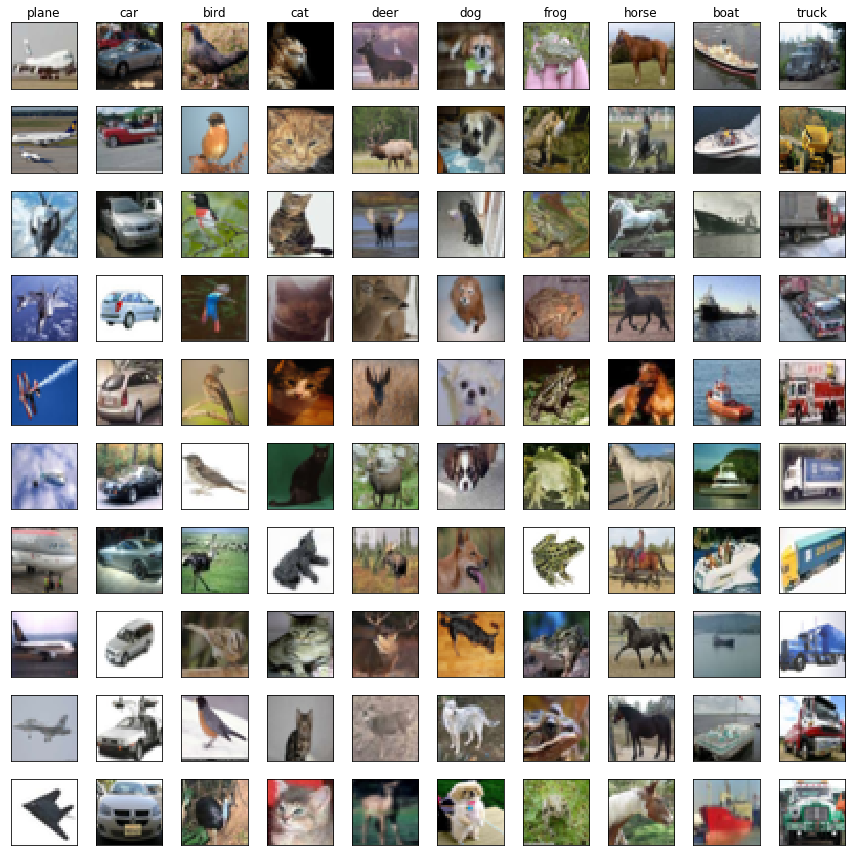

In [5]:
label = {0: 'plane', 1: 'car', 2:'bird', 3:'cat', 4:'deer', 
         5:'dog', 6:'frog', 7:'horse', 8:'boat', 9: 'truck'}

rows, cols = 10, 10
def plot_samples(x_train, y_train, rows, cols):
    
    fig = plt.figure(figsize=(12,12))
    g_s = gridspec.GridSpec(rows, cols)
    # g_s.update(left=0.1,right=0.9,wspace=0.05, top=0.9, bottom=0.1)
    ax = {}
    
    for i in range(cols):
        sample_pics = x_train[(y_train == i).reshape(-1)]
        for j in range(rows):
            num_samples = sample_pics.shape[0]
            random_idx = np.random.choice(num_samples, replace=False) 
            sample_pic = x_train[(y_train == i).reshape(-1)][random_idx]

            ax[(i, j)] = fig.add_subplot(g_s[j, i])
            ax[(i, j)].set_xticks([])
            ax[(i, j)].set_yticks([])
            ax[(i, j)].imshow(sample_pic)
        ax[(i, 0)].set_title(label[i])
    fig.tight_layout()
plot_samples(x_train, y_train, rows, cols);

### Observations
- Some images are not completely centered (padding and sub-sampling might help)
- Background color is diverse within subgroups (model may not train on color scheme of photos?)
- The entire object is contained in each image (easier time for recognition)
- the images are all the same size (no cropping, padding or subsampling necessary)
- there is a perfect distribution of classes (oversampling not necessary)

### Pre-processing data
A good bet is to normalize the data; translate the mean to center about zero and scale the spread to have a standard deviation of 1.

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical


# Data metadata
num_classes = 10
num_train = x_train.shape[0]
in_dim = x_train.shape[1:]

data = ImageDataGenerator(samplewise_center=True, 
                          samplewise_std_normalization=True,
                          horizontal_flip=True)

data.fit(x_train)

# Convert y_train to one hot encoding of classes(num_examples x num_classes)
y_encod = to_categorical(y_train, num_classes)

# TODO:
# Add Data Augmentation
# Add padding: Add pixels around image and pick 32x32 not centered crops

### Simple Deep Convolutional Neural Network

In [9]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from keras import optimizers

# hyper parameters:
p = 0.25  # Dropout probability 
k = 3     # kernel size for convolution
f1 = 32   # number of filters, convolution 1
f2 = 64   # number of filters, convolution 2

model = Sequential(
        [Conv2D(f1, (k, k), padding='same', name='First-Convolution', input_shape=in_dim),
         Activation('relu', name='First-Relu'),
         Conv2D(f1, (k, k), padding='same', name='Second-Convolution'),
         Activation('relu', name='Second-Relu'),
         MaxPooling2D((2, 2), name='First-Max-Pool'),
         Dropout(p, name='First-Dropout'),
         Conv2D(f2, (k, k), padding='same', name='Third-Convolution'),
         Activation('relu', name='Third-Relu'),
         Conv2D(f2, (k, k), padding='same', name='Fourth-Convolution'),
         Activation('relu', name='Fourth-Relu'),
         MaxPooling2D((2, 2), name='Second-Max-Pool'),
         Dropout(p, name='Second-Dropout'),
         Flatten(name='Flatten'),
         Dense(512, name='First-Affine'),
         Activation('relu', name='Fifth-Relu'),
         Dropout(2*p, name='Third-Dropout'),
         Dense(10, name='Final-Connected-Layer'),
         Activation('softmax', name='Softmax')
        ])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First-Convolution (Conv2D)   (None, 32, 32, 32)        896       
_________________________________________________________________
First-Relu (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
Second-Convolution (Conv2D)  (None, 32, 32, 32)        9248      
_________________________________________________________________
Second-Relu (Activation)     (None, 32, 32, 32)        0         
_________________________________________________________________
First-Max-Pool (MaxPooling2D (None, 16, 16, 32)        0         
_________________________________________________________________
First-Dropout (Dropout)      (None, 16, 16, 32)        0         
_________________________________________________________________
Third-Convolution (Conv2D)   (None, 16, 16, 64)        18496     
__________

### Things to try:
- leaky relu
- Maxout (Goodfellow et al.)


### Model Architecture

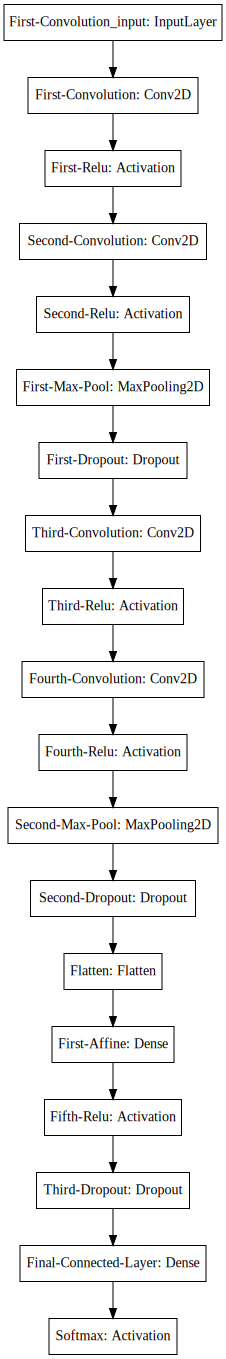

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Define Optimization Parameters

In [11]:
SGD = optimizers.SGD(lr=0.001, 
                     decay=.0001, 
                     momentum=0.9, 
                     nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['categorical_accuracy'])

### Deciding on the Best Learning Rate Intial Value
One technique talked about in Fast.ai was to plot an increasing learning rate value against the loss value to see what an ideal learning rate would be for a new architecture. To do this, after a batch of data is ran through the model, the loss is measured and recorded along with the learning rate. Then the learning rate is increased by a certain amount (in this case, we're looking at exponentially growing the learning rate). When plotted, there should be a minimum loss value for a range of learning rates used on the model. Right before this region is a good place to pick an initial learning rate for training a model.

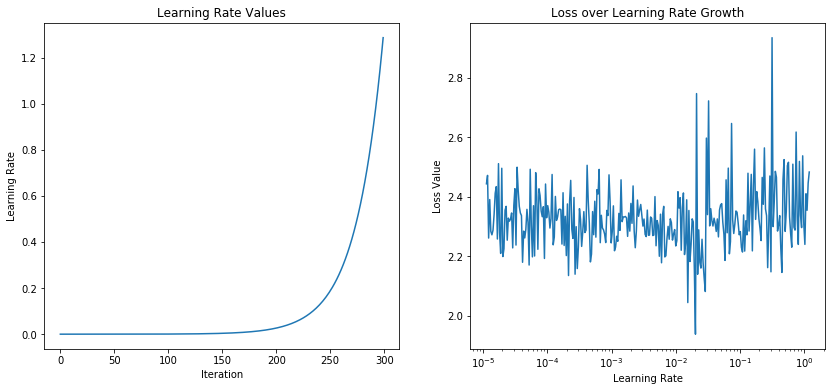

In [318]:
from keras.callbacks import Callback
import keras.backend as K

# Smooth out learning history
def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


class LearningRateBounds(Callback):
    """
    Learning Rate Scheduler and logger.
    args:
    base_lr: initial learning rate
    gamma: constant for exponential growth
    """
    def __init__(self, base_lr, max_lr, gamma=1.04, total_iters, linear=True):
        super(LearningRateBounds, self).__init__()
        self.gamma = gamma
        self.iteration = 0
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.linear = linear
        self.total_iters = total_iters
        
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lrates = []
        self.lr_linspace = np.linspace(self.base_lr, 
                                       self.max_lr,
                                       self.total_iters)
        
    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        
        if self.linear:
            K.set_value(self.model.optimizer.lr, 
                        self.lr_linspace[batch])
        else:
            K.set_value(self.model.optimizer.lr, 
                        self.base_lr * (self.gamma) ** self.iteration)
        
        self.losses.append(logs.get('loss'))
        self.lrates.append(K.eval(self.model.optimizer.lr))
        
    def on_train_end(self, batch, logs=None):
        fig = plt.figure(figsize=(14,6))
        ax = fig.add_subplot(121)
        ax.set_title('Learning Rate Values')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Learning Rate')
        ax.plot(np.arange(self.iteration), self.lrates)

        ax2 = fig.add_subplot(122)
        ax2.set_title('Loss over Learning Rate Growth')
        ax2.set_xlabel('Learning Rate')
        ax2.set_ylabel('Loss Value')
        ax2.set_xscale('log')
        ax2.plot(moving_average(self.lrates), self.losses[5 - 1:])
        
num_epoch = 300
num_batch = 10
lrate_mdl = model

# Start at a super small learning rate, initiate the learning scheduler
K.set_value(lrate_mdl.optimizer.lr, 0.00001)
lr_Schedule = [LearningRateBounds(base_lr=K.eval(lrate_mdl.optimizer.lr))]

# Flow training data through pre-processing pipeline
data_flow = data.flow(x_train, y_encod, batch_size=num_batch)

hist = lrate_mdl.fit_generator(data_flow,
                               epochs=num_epoch,
                               steps_per_epoch=1,
                               callbacks=lr_Schedule,
                               verbose=0)


As you can see in the plot to the right, it is not too clear on where the valley is with the learning rate and loss value. Well, that's machine learning for you. In an update to this post I will do some troubleshooting and look over this further, but the best I can ascertain from the visualization as it stands is a good initial learning rate would be in the $10^{-3}$ range, as it looks like theres a dip right at the $10^{-2}$.

### Technique: Cycling Learning Rate

One cool technique for optimizing the learning rate is the idea of cycling the learning rate values -- increasing the learning rate (instead of decaying it) as a means of helping the model hop out of local minimums and continue gradient descent to the best possible minima. Below is a callback implementation of the algorithm presented in the arXiv paper: https://arxiv.org/abs/1506.01186

In [ ]:
from keras.callbacks import Callback

class CycleLR(Callback):
    
    def __init__(self, base_lr=0.0001, max_lr=0.006, step_size=1000, gamma=1.):
        super(CycleLR, self).__init__()
        
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        
        self.scale_function = lambda x: gamma**(x)
        self.scale_mode = 'iterations'
        
        self.clr_iterations = 0
        self.trn_iterations = 0
        
        self.history = {}
        
        self._reset()
        
    def _reset(self, new_base_lr=None, new_max_lr=None, new_step_size=None):
        """
        Resets the learning rate, cycle iterations
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
            
        self.clr_iterations = 0
    
    
    def clr(self):
        """
        Cycle Learning Rate Algorithm
        """
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        
        diff = self.max_lr - self.base_lr
        scale = np.maximum(0, (1-x)) * self.scale_function(cycle)
        return (
                self.base_lr + 
                diff * scale *
                self.scale_function(self.clr_iterations)
               )
                
    def on_train_begin(self, log={}):
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

        self.losses = []
        self.lrates = []
         
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        
        self.trn_iterations += 1
        self.clr_iterations += 1
        
        curr_lr = K.get_value(self.model.optimizer.lr)
        
        self.losses.append(logs.get('loss'))
        self.lrates.append(curr_lr)
        
        self.history.setdefault('lr', []).append(curr_lr)
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        # Cycle the Learning Rate
        K.set_value(self.model.optimizer.lr, self.clr())
    

### Using CLR to find optimal LR:
Next in this post, I will train the model without the learning rate scheduler (control group), then train it with the scheduler written above. I'll compare the loss and accuracy of the model against a validation set for these two learning methods to validate my hypothesis that cycling the learning rate is in fact an ideal method to employ. 

In [ ]:
from CustomCallback import CyclicLR

# Iterations
num_epochs = 3
batch_size = 32
iters_per_epoch = num_train // batch_size
cycle_step_size = iters_per_epoch * num_epochs  # recommended setting per ArXiv paper

# Learning Rate Scheduler
clr = CyclicLR(base_lr=0.00001, 
               max_lr=0.06, 
               step_size=cycle_step_size, 
               mode='triangular')

SGD = optimizers.SGD(lr=0.001, 
                     decay=.0001, 
                     momentum=0.9, 
                     nesterov=True)

model.compile(loss='categorical_crossentropy', 
              optimizer=SGD, 
              metrics=['categorical_accuracy'])

# Flow training data through pre-processing pipeline
data_flow = data.flow(x_train, y_encod, batch_size=batch_size)

hist = model.fit_generator(data_flow,
                           epochs=num_epochs,
                           callbacks=[clr],
                           verbose=0)


4686